In [26]:
# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

# sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# youtube
from pytube import YouTube

# image operation
import cv2
from PIL import Image

# keras 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3 as inc_net

# lime
import lime
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.2.4


In [24]:
def scrape_frames(video_name, dest_path, every_x_frame, n_images, skip_seconds):
    # function for scraping frames from videos
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: 
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                cv2.imwrite(dest_path + "_" + str(img_count) + '.jpg', image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
        
def move_random_files(path_from, path_to, n):
    # function for moving random files from one directory to another (used for creating train and test set)
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    # function for previewing a random image from a given directory
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
def img_to_1d_greyscale(img_path, size):
    # function for loading, resizing and converting an image into greyscale
    # used for logistic regression
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

def show_image(image):
    # function for viewing an image
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()

def transform_image(path, size):
    # function for transforming images into a format supported by CNN
    x = load_img(path, target_size=(size[0], size[1]))
    x = img_to_array(x) / 255
    x = np.expand_dims(x, axis=0)
    return (x)

def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)

## Download videos

In [13]:
megaman3_video = YouTube('https://www.youtube.com/watch?v=3U0taIY0Jo8')

In [14]:
print('Title:', megaman3_video.title, '---')
stream = megaman3_video.streams.filter(file_extension = 'mp4').all()
for i in stream:
    print(i)

Title: NES Longplay Mega Man 3 ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401e">
<Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d4015">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [15]:
# download the video
megaman3_video.streams.get_by_itag(18).download()

'/home/ville/Documents/Data_Science/megaman_classifier_cnn/NES Longplay Mega Man 3.mp4'

In [16]:
megaman4_video = YouTube('https://www.youtube.com/watch?v=vlBYMTGfWMs&t=1s')

In [17]:
print('Title:', megaman4_video.title, '---')
stream = megaman4_video.streams.filter(file_extension = 'mp4').all()
for i in stream:
    print(i)

Title: NES Longplay Mega Man 4 ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401e">
<Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d4015">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400c">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


In [18]:
megaman4_video.streams.get_by_itag(18).download()

'/home/ville/Documents/Data_Science/megaman_classifier_cnn/NES Longplay Mega Man 4.mp4'

## Cut frames from YouTube Video

In [20]:
import scrape_frames

In [33]:
# Megaman3
scrape_frames('NES Longplay Mega Man 3.mp4',
             'training_set/megaman3/megaman3',
             every_x_frame = 50,
             n_images = 5000,
             skip_seconds = 60)

In [32]:
# Megaman4
scrape_frames('NES Longplay Mega Man 4.mp4',
             'training_set/megaman4/megaman4',
             every_x_frame = 50,
             n_images = 5000,
             skip_seconds = 60)

## Data preprocessing

In [34]:
move_random_files(path_from = 'training_set/megaman3/',
                 path_to = 'test_set/megaman3/',
                 n = 1000)

In [35]:
move_random_files(path_from = 'training_set/megaman4/',
                 path_to = 'test_set/megaman4/',
                 n = 1000)

### Preview images

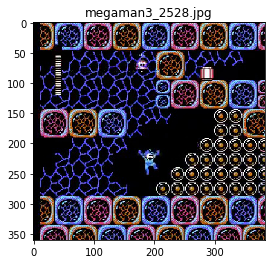

Dimensions: (384, 360) Total pixels: 138240


In [36]:
preview_random_image('training_set/megaman3/')

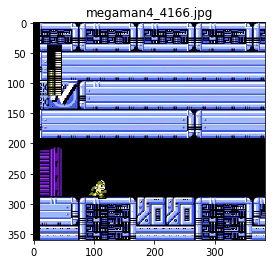

Dimensions: (384, 360) Total pixels: 138240


In [37]:
preview_random_image('training_set/megaman4/')

#### Compare openCV and Keras rescaling of image:

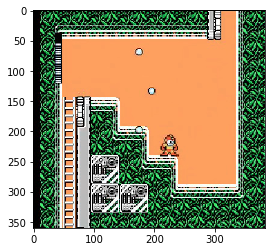

In [39]:
im = cv2.imread('training_set/megaman3/megaman3_1.jpg')
plt.imshow(im)

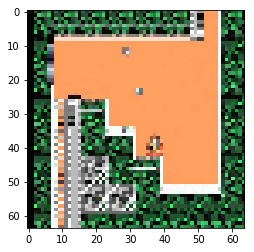

In [41]:
im_cv = cv2.resize(im, (64, 64))
plt.imshow(im_cv)

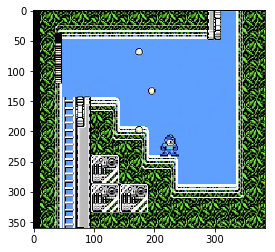

In [43]:
im = load_img('training_set/megaman3/megaman3_1.jpg')
plt.imshow(im)

## Prepare training and test sets

In [44]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                target_size = (64, 64),
                                                batch_size = 32,
                                                class_mode = 'binary')

test_set = test_datagen.flow_from_directory('test_set',
                                           target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [45]:
# Check classes for future reference
labels_index = {0 : 'megaman3', 1 : 'megaman4'}
training_set.class_indices

{'megaman3': 0, 'megaman4': 1}

### Preview transformations

In [47]:
files = os.listdir('training_set/megaman3/')
img_name = files[randint(0, len(files)-1)]

img = load_img('training_set/megaman3/' + img_name)

x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                               save_to_dir='preview', save_prefix='megaman3', save_format='jpeg'):
    i += 1
    if i > 20:
        break

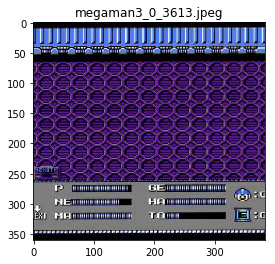

Dimensions: (384, 360) Total pixels: 138240


In [48]:
preview_random_image('preview/')

## Convolutional Neural Network

In [50]:
cnn_classifier = Sequential()

# 1st conv. layer
cnn_classifier.add(Conv2D(32, (3,3), input_shape = (64, 64, 3), activation = 'relu'))
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd conv. layer
cnn_classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # No need to specify input shape 
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd conv. layer
cnn_classifier.add(Conv2D(64, (3, 3), activation = 'relu')) # No need to specify input shape 
cnn_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# flattening
cnn_classifier.add(Flatten())

# Full connection
cnn_classifier.add(Dense(units = 64, activation = 'relu'))
cnn_classifier.add(Dropout(0.5)) # Pretty aggressive
cnn_classifier.add(Dense(units = 1, activation = 'sigmoid'))

cnn_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

In [52]:
# Compile CNN
cnn_classifier.compile(optimizer = 'adam',
                      loss = 'binary_crossentropy',
                      metrics = ['accuracy'])

In [ ]:
# make sure we are running this on GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [53]:
cnn_classifier.fit_generator(training_set,
                            steps_per_epoch = 2000,
                            epochs = 10,
                            validation_data = test_set,
                            validation_steps = 2000)

Epoch 1/10
2000/2000 [==============================] - 298s 149ms/step - loss: 0.2042 - acc: 0.9052 - val_loss: 0.0760 - val_acc: 0.9709
Epoch 2/10
2000/2000 [==============================] - 292s 146ms/step - loss: 0.0543 - acc: 0.9791 - val_loss: 0.1188 - val_acc: 0.9645
Epoch 3/10
2000/2000 [==============================] - 290s 145ms/step - loss: 0.0380 - acc: 0.9855 - val_loss: 0.0936 - val_acc: 0.9736
Epoch 4/10
2000/2000 [==============================] - 291s 145ms/step - loss: 0.0293 - acc: 0.9884 - val_loss: 0.0586 - val_acc: 0.9830
Epoch 5/10
2000/2000 [==============================] - 291s 145ms/step - loss: 0.0269 - acc: 0.9890 - val_loss: 0.0401 - val_acc: 0.9870
Epoch 6/10
2000/2000 [==============================] - 292s 146ms/step - loss: 0.0258 - acc: 0.9895 - val_loss: 0.1202 - val_acc: 0.9745
Epoch 7/10
2000/2000 [==============================] - 291s 146ms/step - loss: 0.0238 - acc: 0.9904 - val_loss: 0.0436 - val_acc: 0.9854
Epoch 8/10
2000/2000 [============

In [54]:
# save model and weights
cnn_classifier.save_weights('megaman3_vs_megaman4_weights_dropout.h5')
cnn_classifier.save('megaman3_vs_megaman4_model_dropout.h5')

In [57]:
# load the model
cnn_classifier = keras.models.load_model('megaman3_vs_megaman4_model_dropout.h5')

## Evaluate results

In [58]:
size = (64, 64)
X_eval = list()
y_eval = list()

# megaman3
files = os.listdir('test_set/megaman3')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/megaman3/' + files[i + 1], size))
    y_eval.append(0)
    
# megaman4
files = os.listdir('test_set/megaman4')
files.sort()

for i in range(0, len(files) - 1):
    X_eval.append(transform_image('test_set/megaman4/' + files[i + 1], size))
    y_eval.append(1)
    
# stack arrays
X_eval = np.vstack(X_eval)

In [59]:
cnn_pred = cnn_classifier.predict_classes(X_eval, batch_size = 32)

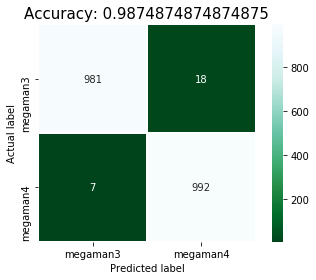

In [60]:
pretty_cm(cnn_pred, y_eval, ['megaman3', 'megaman4'])